In [1]:
import numpy as np
import matplotlib.pyplot as plt

from C4_theo_asymptotique__trapz import C4_court, C4_long
from DoubleRigidWallOverdampedBrownExp_Cython import RigidWallOverdampedLangevin3D
import cythonised_simu_part

from scipy.integrate import quad
from scipy.io import loadmat
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from numpy import trapz

import csv


def cm2inch(value):
    return value / 2.54

from tqdm import tqdm
# axes.xaxis.set_tick_params(direction='in', which='both')
# axes.yaxis.set_tick_params(direction='in', which='both')


mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 1
mpl.rcParams["figure.dpi"] = 200
from matplotlib import rc

rc("font", family="serif")
rc("text", usetex=False)
rc("xtick", labelsize="medium")
rc("ytick", labelsize="medium")
rc("axes", labelsize="large")

# Model de diffusion dans un canal étroit 

Code origine : $\mathrm{\color{red}{Cumulant4\_fonction.py}}$ et  $\mathrm{\color{red}{DoubleRigidWallOverdampedBrownExp\_Cython.pyx}}$

Auteur : $\mathrm{\color{purple}{Élodie ~MILLAN}}$

Date : 14/01/2022


- $2H_p$ : hauteur du canal;
- $a$ : rayon de la particule;
- On pose $H = H_p -a$
- $\eta_0$ : viscosité du fluide
- $D_\|(z) = \frac{k_\mathrm{B}T}{6 \pi \eta_\| a}$ : coeficient de diffusion colinéaire au mur, avec $\eta_\| (z) = \eta_0 \left( 1 - \frac{9a}{16(z+a)} +  \left( \frac{a}{8(z+a)} \right)^3 - \left( \frac{45a}{256(z+a)} \right)^4 - \left( \frac{a}{16(z+a)} \right)^5 \right)^{-1}$. 
- $D_\perp(z) = \frac{k_\mathrm{B}T}{6 \pi \eta_\perp a}$ : coeficient de diffusion transverse au mur, avec $\eta_\perp(z) = \eta_0 \frac{6z^2 + 9az + 2a^2}{6z^2 + 2az}$.


Les viscosités effectives du fluide, transverse et colinaires, dû à la présence des deux mur s'écrivent : $\eta_\mathrm{eff} = \eta_\mathrm{B} + \eta_\mathrm{T} - \eta_0$, où le mur du bas est placé en $-H_\mathrm{P}$ et le mur du haut est en $+H_\mathrm{P}$. Les deux murs sont donc distant de $2 H_\mathrm{P}$.

La particule est soumise au poids et à la répulstion electronique des deux mur, donc le potentiel vaud :

\begin{equation}
    V = B k_\mathrm{B}T \left( \exp \left( -\frac{z_\mathrm{B}}{l_\mathrm{D}} \right) + \exp \left( -\frac{z_\mathrm{T}}{l_\mathrm{D}} \right)  \right) + \frac{k_\mathrm{B} T }{l_\mathrm{B}}z = B k_\mathrm{B}T \left( \exp \left( -\frac{(H+z)}{l_\mathrm{D}} \right) + \exp \left( -\frac{(H-z)}{l_\mathrm{D}} \right)  \right) + \frac{k_\mathrm{B} T }{l_\mathrm{B}}z.
\end{equation}
avec $z_\mathrm{B} = H+z$ la distance entre la particule (en $z$) et le mur du bas ; et $z_\mathrm{T} = H-z$, celle entre la particule et le mur du haut.

La force électrostatique vaud alors :
\begin{equation}
    F_\mathrm{elec} = -\frac{\partial V_\mathrm{elec}}{\partial z} = \frac{B k_\mathrm{B}T }{l_\mathrm{D}} e^{- \frac{H}{l_\mathrm{D}}} \left( \exp \left( -\frac{z}{l_\mathrm{D}} \right) - \exp \left( \frac{z}{l_\mathrm{D}} \right)  \right),
\end{equation}
et la force gravitaire :
\begin{equation}
    F_\mathrm{grav} = -\frac{k_\mathrm{B} T }{l_\mathrm{B}}.
\end{equation}

La PDF de $z$ s'écrit alors :
\begin{equation}
    P_\mathrm{eq}(z) = \frac{1}{N} \exp \left( -\frac{V}{k_\mathrm{B}T} \right) = \frac{1}{N} e^{ - B  \left( \exp \left( -\frac{(H+z)}{l_\mathrm{D}} \right) + \exp \left( -\frac{(H-z)}{l_\mathrm{D}} \right)  \right) - \frac{z}{l_\mathrm{B}}},
\end{equation}

\begin{equation}
    P_\mathrm{eq}(z) = \frac{1}{N} e^{ - B \exp \left( -\frac{H}{l_\mathrm{D}} \right) \left \{ \exp \left( -\frac{z}{l_\mathrm{D}} \right) + \exp \left( +\frac{z}{l_\mathrm{D}} \right)  \right \} - \frac{z}{l_\mathrm{B}}}.
\end{equation}

Le spurious drift s'écrit :
\begin{equation}
    F_\mathrm{spurious} = k_\mathrm{B}T \frac{D_{\perp,\mathrm{eff}} '(z)}{D_{\perp,\mathrm{eff}}(z)} = D_{\perp,\mathrm{eff}} '(z) \gamma_{\perp,\mathrm{eff}}(z) = - \frac{k_\mathrm{B}T (\eta_\mathrm{B}'(z) + \eta_\mathrm{T}'(z))}{6 \pi a (\eta_\mathrm{B}(z) + \eta_\mathrm{T}(z) - \eta_0)^2} \gamma_{\perp,\mathrm{eff}}(z)
\end{equation}
avec :
\begin{equation}
    \eta_\mathrm{eff,\perp}'(z) = \eta_\mathrm{B}'(z) + \eta_\mathrm{T}'(z) = \eta_0 \left( \frac{a}{(H-z)^2} - \frac{a}{(H+z)^2} - \frac{3(8a-9)}{2(a+3H-3z)^2} + \frac{3(8a-9)}{2(a+3H+3z)^2}  \right) 
\end{equation}


$\mathrm{B}=\mathrm{Bottom}$, $\mathrm{T}=\mathrm{Top}$

Équation de Langevin overdamped:
\begin{equation}
   \gamma_\mathrm{eff} (z) \frac{\mathrm{d}z}{\mathrm{d}t} = F_\mathrm{grav} + F_\mathrm{elec} - F_\mathrm{spurious} + w(z) \frac{\mathrm{d}B_t}{\mathrm{d}t}
\end{equation}

\begin{equation}
   z_{i+1} = z_i + \left( F_\mathrm{grav} + F_\mathrm{elec} - F_\mathrm{spurious} + w(z) \frac{\mathrm{d}B_t} {\mathrm{d}t} \right) \frac{\mathrm{d}t}{\gamma_\mathrm{eff}(z)}
\end{equation}

\begin{equation}
   z_{i+1} = z_i + \left( F_\mathrm{grav} + F_\mathrm{elec} \right) \frac{\mathrm{d}t}{\gamma_\mathrm{eff} (z)} - D_\mathrm{eff,\perp}' \mathrm{d}t  + w(z) \mathrm{RNG} \mathrm{d}t.
\end{equation}


In [2]:

F_elec = lambda z: B * kBT/lD * np.exp(-H/lD) * (np.exp(-z/lD) - np.exp(z/lD))
F_grav = lambda z: - kBT/lB*np.ones(len(z))

P_eq = lambda z: np.exp(-B*np.exp(-H/lD)*(np.exp(-z/lD) + np.exp(z/lD)) - z/lB)



def gamma_z_eff(zi_1, a, eta, H):
    """
    Formule de Padé
    """
    # Mur Top
    gam_z = (
        6
        * np.pi
        * a
        * eta
        * (
            (
                (6 * (H-zi_1)**2 + 9*a*(H-zi_1) + 2*a**2)
                / (6 * (H-zi_1)**2 + 2*a*(H-zi_1))
            )
        )
    )
    # Mur Bottom
    gam_z_2 = (
        6
        * np.pi
        * a
        * eta
        * (
            (
                (6 * (H+zi_1)**2 + 9*a*(H+zi_1) + 2*a**2)
                / (6 * (H+zi_1)**2 + 2*a*(H+zi_1))
            )
        )
    )

    gam_z_0 = 6 * np.pi * a * eta

    return (gam_z + gam_z_2 - gam_z_0)

def gamma_xy_eff(zi_1, a, eta, H):
    """
    Formule de Libshaber
    """
    # Mur Top
    xi_T = a / ((H-zi_1) + a)
    gam_xy_T = (
        6
        * np.pi
        * a
        * eta
        * (
            1
            - 9 / 16 * xi_T
            + 1 / 8 * xi_T**3
            - 45 / 256 * xi_T ** 4
            - 1 / 16 * xi_T ** 5
        )
        ** (-1)
    )
    
    #Mur Bottom
    xi_B = a / ((H+zi_1) + a)
    gam_xy_B = (
        6
        * np.pi
        * a
        * eta
        * (
            1
            - 9 / 16 * xi_B
            + 1 / 8 * xi_B**3
            - 45 / 256 * xi_B ** 4
            - 1 / 16 * xi_B ** 5
        )
        ** (-1)
    )

    gam_xy_0 = 6 * np.pi * a * eta

    return (gam_xy_T + gam_xy_B - gam_xy_0)


def Dprime_z_eff(zi, kBT, eta, a, H):
    # Spurious force pour corriger overdamping (Auteur: Dr. Maxime Lavaud)
    eta_B = lambda zi: eta * (6*(H+zi)**2 + 9*a*(H+zi) + 2*a**2) / (6*(H+zi)**2 + 2*a*(H+zi))
    eta_T = lambda zi: eta * (6*(H-zi)**2 + 9*a*(H-zi) + 2*a**2) / (6*(H-zi)**2 + 2*a*(H-zi))
    
    eta_B_primes = -(a * eta * (2 * a ** 2 + 12 * a * (H + zi) + 21 * (H + zi) ** 2)) / (
        2 * (H + zi) ** 2 * (a + 3 * (H + zi)) ** 2
    )
    eta_T_primes = (
        a
        * eta
        * (2 * a ** 2 + 12 * a * (H-zi) + 21 * (H-zi) ** 2)
        / (2 * (a + 3*H - 3*zi) ** 2*(H-zi) ** 2)
    )
    
    eta_eff = eta_B(zi) + eta_T(zi) - eta
    eta_eff_prime = eta_B_primes + eta_T_primes

    return  - kBT / (6*np.pi*a) * eta_eff_prime / eta_eff**2


V_theo = lambda z: B*kBT*np.exp(-H/lD)*(np.exp(-z/lD) + np.exp(+z/lD)) + kBT/lB*z
D_perp = lambda z: kBT/gamma_z_eff(z, a, eta, H)
D_para = lambda z: kBT/gamma_xy_eff(z, a, eta, H)
D_0 = lambda z: kBT/(6*np.pi*eta*a*np.ones(len(z)))

F_spurious = lambda z: Dprime_z_eff(z, kBT, eta, a, H)*gamma_z_eff(z, eta, a, H)

# Analyse $C4_\|$

In [3]:
dossier = "C4_Datas/lD_5p000000e-07_lB_5p970338e-07_B_4p800000e+00_H_2p500000e-06_a_1p500000e-06_dt_1p000000e-01_Nt_1000000_Ntsub_1_/"

fileC4 = dossier+"C4_lD_5p000000e-07_lB_5p970338e-07_B_4p800000e+00_H_2p500000e-06_a_1p500000e-06_dt_1p000000e-01_Nt_1000000_Ntsub_1_.csv"


lD = float(fileC4.replace("p", ".").split("_")[-16])
lB = float(fileC4.replace("p", ".").split("_")[-14])
B = float(fileC4.replace("p", ".").split("_")[-12])
H = float(fileC4.replace("p", ".").split("_")[-10])
a = float(fileC4.replace("p", ".").split("_")[-8])
dt = float(fileC4.replace("p", ".").split("_")[-6])
Nt = int(fileC4.replace("p", ".").split("_")[-4])
Nt_sub = int(fileC4.replace("p", ".").split("_")[-2])
# file.replace("p", ".").split("_")

dataC4  = np.loadtxt(fileC4, delimiter= ",")

kBT=1.38e-23*300
eta=0.001

dx = 1e-8 # Pas d'integration numérique pour les calcules théoriques

zz = np.linspace(-H+H*1e-3, H-H*1e-3, 1000)


list_dt_c4 = np.array([], dtype=int)
for i in range(len(str(Nt)) - 1):
    # Take just 10 points by decade.
    list_dt_c4 = np.concatenate(
        (
            list_dt_c4,
            np.arange(10 ** i, 10 ** (i + 1), 10 ** i, dtype=int),
        )
    )
tau = list_dt_c4*dt*Nt_sub




In [4]:
np.shape(tau)[0], np.shape(dataC4)[1]

(54, 54)

In [5]:
dataC4 = dataC4[~np.isnan(dataC4).any(axis=1)]
n_simu = np.shape(dataC4)[0]
n_simu

240390

In [6]:
Nt, dt

(1000000, 0.1)

In [7]:
A4_theo = C4_court(Dpara=D_para, Peq=P_eq, kBT=kBT, hmin=-H+H*1e-5, hmax=+H-H*1e-5, dx=dx)
A4_theo

9.85716981181668e-28

In [10]:
D4_theo = C4_long(Dpara=D_para, Dperp=D_perp, Peq=P_eq, H=H, dx=dx, )
D4_theo

1.397640042553425e-26

In [11]:
# def Calcul_D4(dx=dx,r=a, H=H, lB=lB, method = np.trapz):
#     epsilon=H*1e-4
#     P_eq = lambda z: np.exp(-B*np.exp(-H/lD)*(np.exp(-z/lD) + np.exp(z/lD)) - z/lB)
#     a = -H + epsilon
#     b = H - epsilon
#     zz = np.linspace(a, b, int((b-a)/dx))
#     N = method(P_eq(zz),zz)
#     D_para_mean = method( P_eq(zz) * kBT / gamma_xy_eff(zz, r, eta, H) / N, zz) 
    
    
    

    
#     def J(z):
#         if z == a:
#             return 0
#         zp = np.linspace(a, z, int((z-a)/dx))
#         JJ = P_eq(zp)*( kBT / gamma_xy_eff(zp, r, eta, H) - D_para_mean)
#         JJ = method(JJ, zp)
#         return JJ
    
#     JJ = [J(z)**2 for z in zz]
    
#     to_int = JJ / P_eq(zz)/ ( kBT / gamma_z_eff(zz, r, eta, H)) / N
#     D4 = method(to_int, zz)
#     return D4


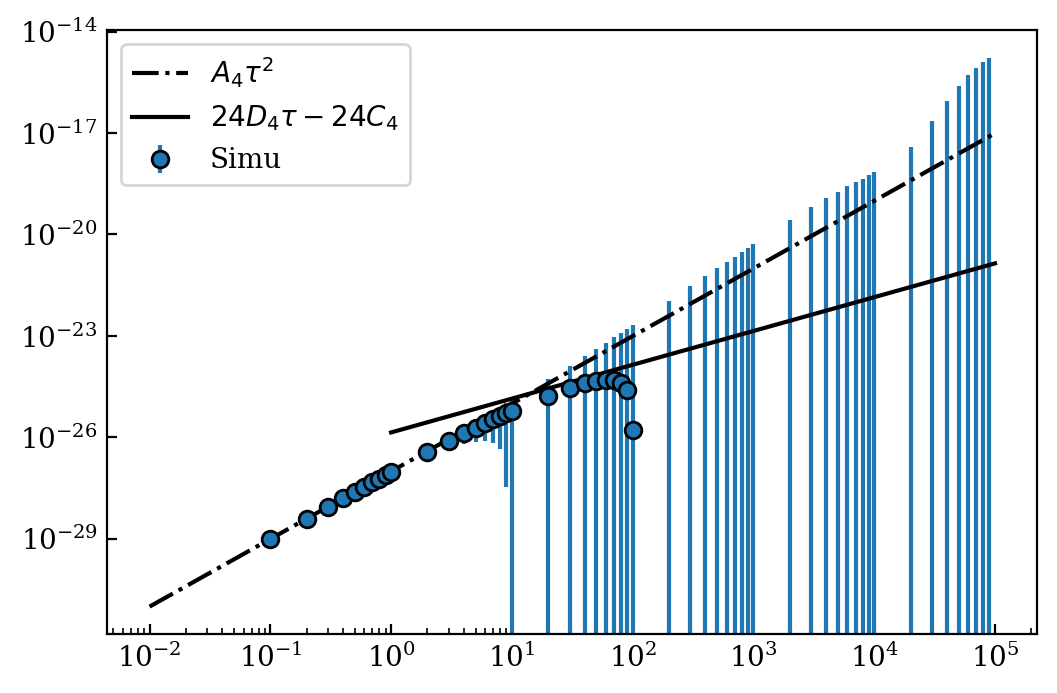

In [12]:
tt_court = np.linspace(1e-2, dt*Nt, 10000)
tt_long = np.linspace(1, dt*Nt, 10000)
# plt.xlim((1e-2, 10))
# plt.ylim((1e-31, 1e-24))
plt.errorbar(tau, np.mean( dataC4, axis=0), yerr=np.std(dataC4, axis=0), fmt="o", label=r"Simu") 
plt.loglog()
plt.plot(tt_court, A4_theo*tt_court**2, "-.k", label=r"$A_4 \tau ^2$")
plt.plot(tt_long, D4_theo*tt_long, "-k", label=r"$24 D_4 \tau - 24 C_4$")
# plt.plot(tt_long, 24*Calcul_D4()*tt_long, ":", label=r"long")

plt.legend()


# plt.savefig("C4_simu_tempsLong_{}".format(np.random.random(1)).replace(".", "p") + ".png")

In [16]:
N_simus = np.unique(np.logspace(np.log(10)/np.log(10), 
                                np.log(100000)/np.log(10),
                                num = 100, 
                                base = 10, 
                                dtype=int))

MeansC4_tau_N = np.zeros([len(N_simus), len(tau)])

for i in range(len(tau)):
    for n, m in enumerate(N_simus):
        
        MeansC4_tau_N[n, i] = np.mean(dataC4[:m, i], axis=0)
        

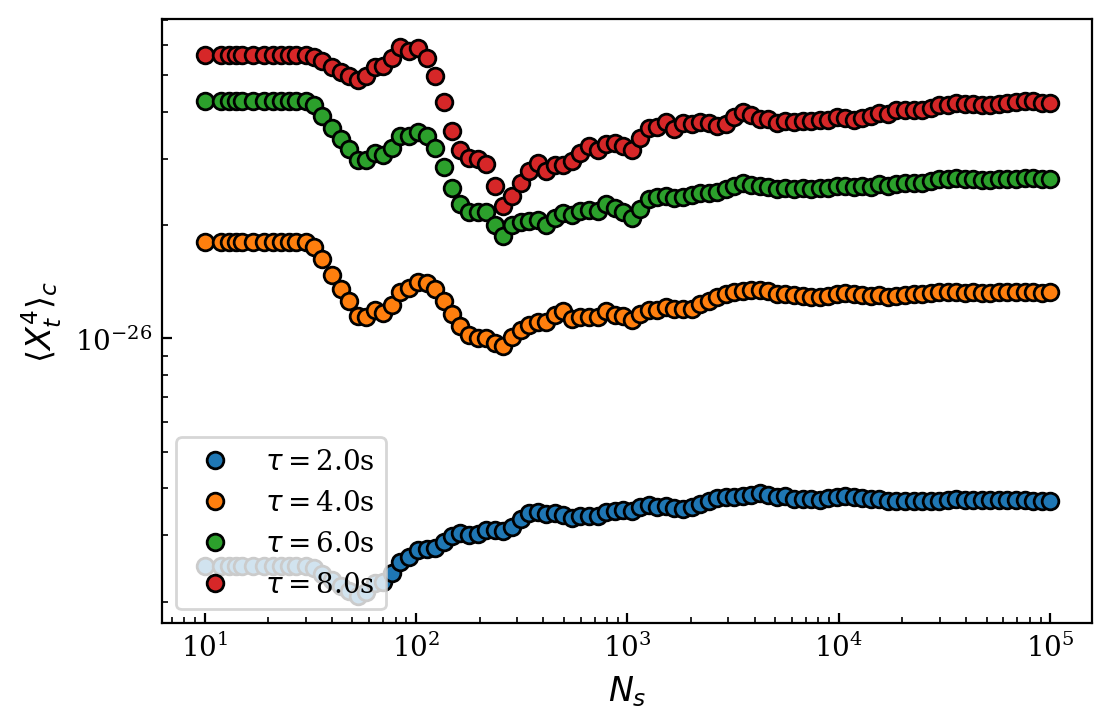

In [17]:
plt.loglog(N_simus, MeansC4_tau_N[:, 10], "o", label=r"$\tau=$"+str(tau[10])+"s")
plt.loglog(N_simus, MeansC4_tau_N[:, 12], "o", label=r"$\tau=$"+str(tau[12])+"s")
plt.loglog(N_simus, MeansC4_tau_N[:, 14], "o", label=r"$\tau=$"+str(tau[14])+"s")
plt.loglog(N_simus, MeansC4_tau_N[:, 16], "o", label=r"$\tau=$"+str(tau[16])+"s")


plt.xlabel(r"$N_s$")
plt.ylabel(r"$\langle X^4_t \rangle_c$")
plt.legend()

In [18]:
Ntau_fix = 10
N_shuffle = 50

MeansC4_shuffled=np.zeros([len(N_simus), N_shuffle, len(tau)])

for t in range(len(tau)):
    
    for s in range(N_shuffle):
        
        new_index= np.arange(np.shape(dataC4)[0])
        np.random.shuffle(new_index)
        data_shuffled = dataC4[new_index,:]
        
        for n, m in enumerate(N_simus):
            MeansC4_shuffled[n, s, t] = np.mean(data_shuffled[:m, t], axis=0)
                    
        # plt.loglog(N_simus, MeansC4_shuffled, "o")
    
# plt.ylabel(r"$\langle C_4 \rangle$")
# plt.xlabel(r"$N_s$")
# plt.title(r"$\tau=$"+str(tau[Ntau_fix])+"s")
# # plt.legend()
# plt.show()

In [19]:
std_MeanC4 = np.zeros([len(N_simus),len(tau)])
# N = [50, 60, 85, 90]
for n, m in enumerate(N_simus):
    for t in range(len(tau)):
        std_MeanC4[n, t] = np.std(MeansC4_shuffled[n, :, t])
        
#     if n in N:
#         plt.loglog(tau, std_MeanC4, "o", label=r"$N_s=$"+str(m))
    
# plt.xlabel(r"$\tau$")
# plt.ylabel(r"$std(\langle C_4 \rangle)$")
# plt.legend()

In [20]:
np.shape(std_MeanC4), len(tau)

((99, 54), 54)

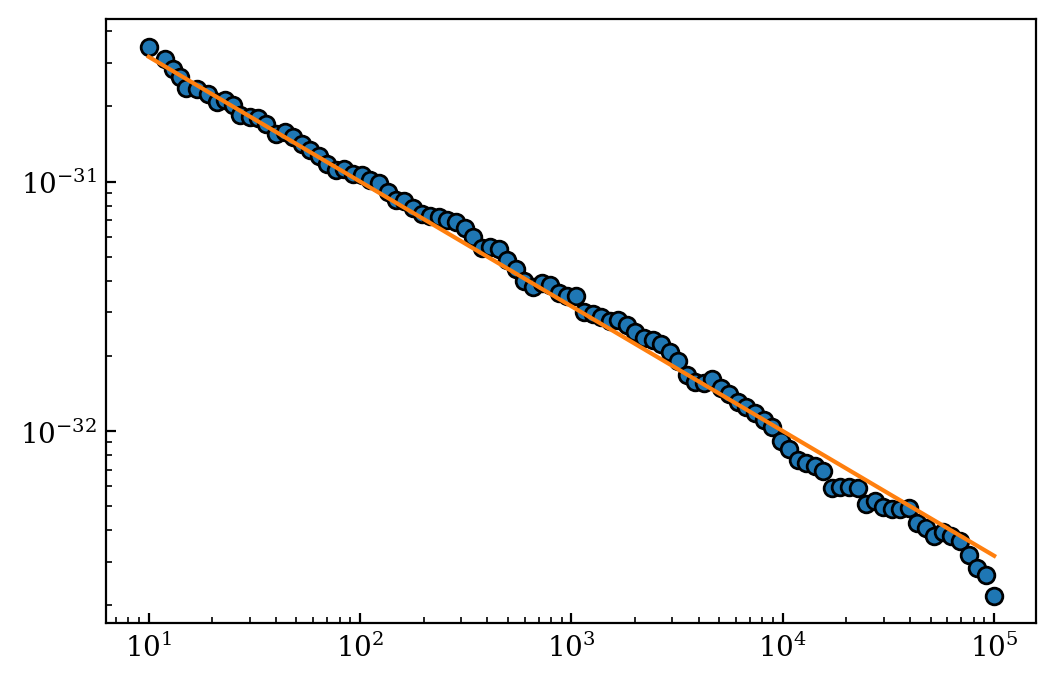

In [21]:
plt.loglog(N_simus, std_MeanC4[:,0], "o")
plt.plot(N_simus, 10e-31/np.sqrt(N_simus), "-")

In [22]:
hist, bins_edge =  np.histogram(MeansC4_tau_N[:,-1], bins=301, density=False)

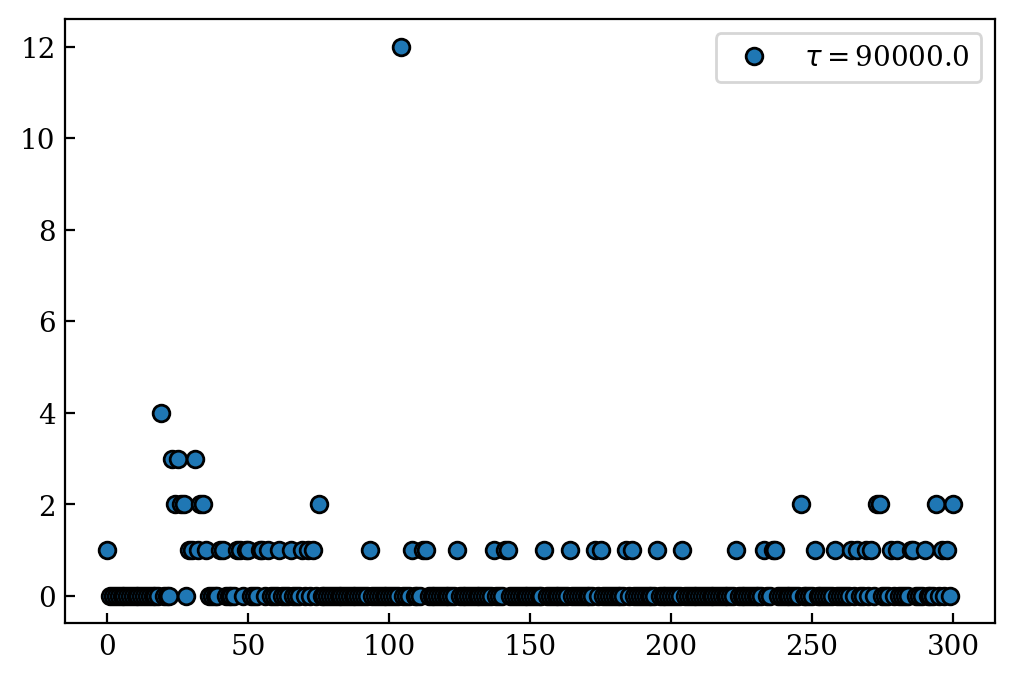

In [23]:
plt.plot( hist , "o", label=r"$\tau=$"+str(tau[-1]))
plt.legend()

In [24]:
stop

NameError: name 'stop' is not defined

In [25]:
simu = RigidWallOverdampedLangevin3D(dt=1e-4, Nt=Nt, a=a, H=H, lD=lD, lB=lB, B=B, Nt_sub=Nt_sub)
simu.trajectory()


In [26]:
Rs = np.zeros([simu.Nt, 3])
Rs[:,0] = simu.x
Rs[:,1] = simu.y
Rs[:,2] = simu.z

In [27]:
tau_x, msd_x = simu.MSD("x")

100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 540.13it/s]


In [28]:
tau_z, msd_z = simu.MSD("z")

100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 509.88it/s]


In [29]:
z = np.linspace(-H, H, 1000)

Dz = np.array([kBT / cythonised_simu_part.gamma_z_eff(i, a,  eta, H) for i in z])
Dx = np.array([kBT / cythonised_simu_part.gamma_xy_eff(i, a,  eta, H) for i in z])
D0 = kBT/(6*np.pi*simu.eta*simu.a)

Peq = P_eq(z)/np.trapz(P_eq(z), z)


mean_Dx = np.trapz(Peq*Dx, z)
mean_Dz = np.trapz(Peq*Dz, z)

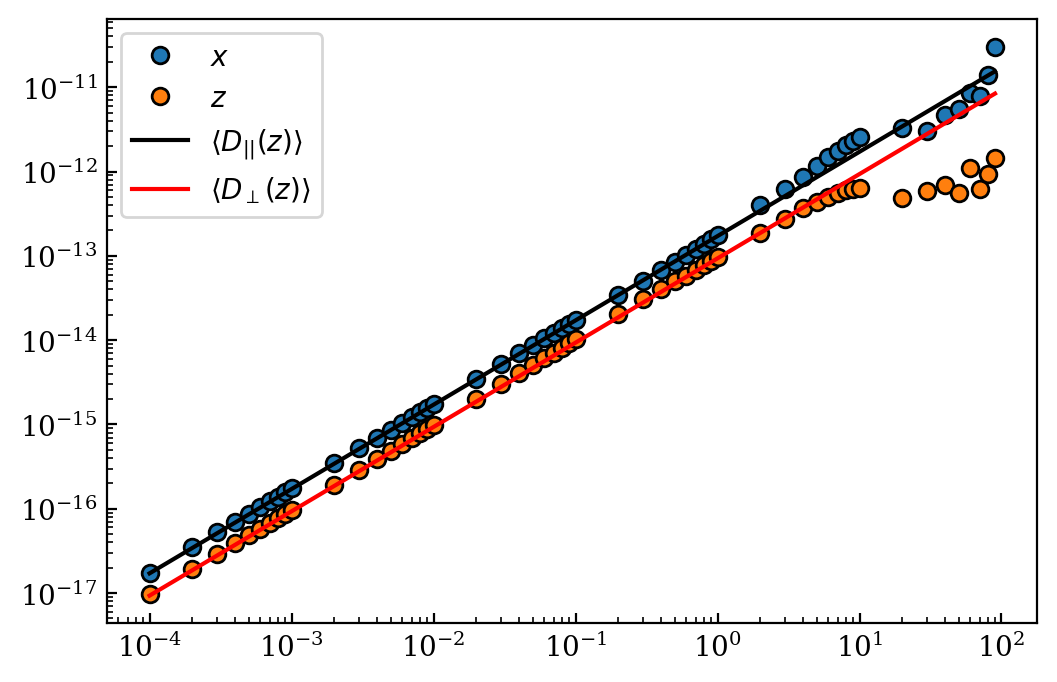

In [30]:
plt.loglog(tau_x, msd_x, "o", label=r"$x$")
plt.loglog(tau_z, msd_z, "o", label=r"$z$")
plt.plot(tau_x, 2*tau_x*mean_Dx, "-k", label=r"$\langle D_{\||}(z) \rangle$")
plt.plot(tau_z, 2*tau_z*mean_Dz, "-r", label=r"$\langle D_{\perp}(z) \rangle$")

plt.legend()

In [33]:
position = Rs[:, 2]
bins=500

hist_z, bin_edges = np.histogram(position[position < 30e-6], bins=bins, density=False)
binsPositions = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf = hist_z / np.trapz(hist_z, binsPositions)

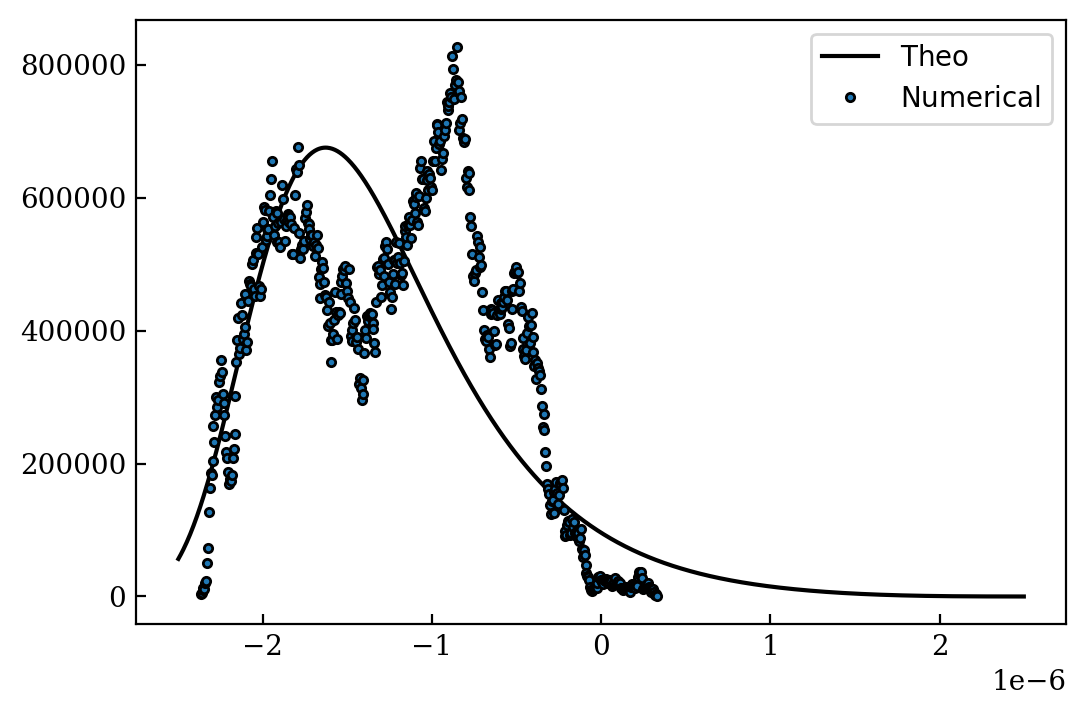

In [34]:
plt.plot(zz, P_eq(zz)/np.trapz(P_eq(zz), zz), "k-", label=r"$\mathrm{Theo}$")

plt.plot(binsPositions, pdf, ".", label=r"$\mathrm{Numerical}$")
plt.legend()

In [35]:
stop

NameError: name 'stop' is not defined

In [41]:
C4_court

<function C4_theo_asymptotique__trapz.C4_court(Dpara, Peq, kBT, hmin, hmax, dx)>

In [43]:
# test
H2 = 7e-6/2
a2 = 0.56e-6
lB2 = 4.12e-21 / (4/3 * np.pi * a**3 * 50 * 9.81)
lD2 = 30e-9
B2 = 4.8

A4_theo_test = C4_court(Dpara=D_para, Peq=P_eq, kBT=kBT, hmin=-H+H*1e-5, hmax=+H-H*1e-5, dx=dx)
D4_theo_test = C4_long(Dpara=D_para, Dperp=D_perp, Peq=P_eq, H=H, dx=dx)


In [44]:
print("A4 = ", A4_theo_test, "/ D4 = ", D4_theo_test)

A4 =  9.85716981181668e-28 / D4 =  1.397640042553425e-26


# Étude de ce $D_4$ qui veux pas converger !!!!!! 

In [45]:
from scipy.integrate import simpson
import time

In [46]:
V = V_theo
Dpara = D_para
Dperp = D_perp

beta = 1 / kBT
hmin=-(H+1e-3*H)
hmax=(H+1e-3*H)
dx = 1e-7

Nt = int((hmax - hmin) / dx)
z = np.linspace(hmin, hmax, Nt, endpoint=True)


VV = [V(i) for i in z]
D_Para = [Dpara(i) for i in z]
D_Perp = [Dperp(i) for i in z]

Z = simpson(y=[np.exp(-beta*VV[i]) for i in range(len(z))], dx=dx)
Peq = [np.exp(-beta * V(i)) / Z for i in z]
Dpara_mean = simpson(y=[Peq[i]*D_Para[i] for i in range(len(z))], dx=dx)

def J(z):
    if z == hmin:
        return 0
    zp = np.linspace(hmin, z, int((z - hmin)/ dx), endpoint=True)
    j = simpson( y=[np.exp(-beta * V(i)) * (Dpara(i) - Dpara_mean) for i in zp] , dx=dx )
    return j

JJ = [J(i) for i in z]

D4_1 = np.trapz( y=[JJ[i]**2 * np.exp(beta*VV[i]) / D_Perp[i] for i in range(len(z))], dx=dx )

In [47]:
# dx = 1e-7
# Nt = int((hmax - hmin) / dx)
# z2 = np.linspace(hmin, hmax, Nt, endpoint=True)
# VV = [V(i) for i in z2]
# D_Para = [Dpara(i) for i in z2]
# D_Perp = [Dperp(i) for i in z2]

# Z = simpson(y=[np.exp(-beta*VV[i]) for i in range(len(z2))], dx=dx)
# Peq = [np.exp(-beta * V(i)) / Z for i in z2]
# Dpara_mean = simpson(y=[Peq[i]*D_Para[i] for i in range(len(z2))], dx=dx)


# JJ2 = [J(i) for i in z2]
# D4_2 = np.trapz( y=[JJ2[i]**2 * np.exp(beta*VV[i]) / D_Perp[i] for i in range(len(z))], dx=dx )

In [48]:

plt.plot(z2, JJ2, label=r"$dx=1e-7$")
plt.plot(z, JJ, label=r"$dx=1e-8$")
plt.xlabel(r"$z$")
plt.ylabel(r"$J(z)$")
plt.legend()
plt.show()
# plt.savefig("J_z_dx.png")

NameError: name 'z2' is not defined

In [49]:
D4_1

4.031464707488844e-33

In [ ]:
np.finfo(np.longdouble)

In [ ]:
np.finfo(np.double)

In [ ]:
drp